In [1]:
import sys
sys.path.insert(1, '/Users/linusrandud/Documents/UoM/ERP/MscDissertation/Deep-Opt')

In [2]:
import torch

from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler

In [3]:
import wandb
import matplotlib.pyplot as plt

In [4]:
# Initialize device
device = torch.device("cpu")
print(device)

# Define the file path and problem type
file_paths = ['../data/qubo/qubo_problem.txt']
problem_type = 'QUBO'
use_wandb = True  # Set to True if using Weights & Biases

cpu


In [5]:
# Parameters
params = {
    'change_tolerance': 20,
    'problem_size': 20,
    'pop_size': 10000,
    'dropout_prob': 0.2,
    'l1_coef': 0.0001,
    'l2_coef': 0.0001,
    'learning_rate': 0.002,
    'max_depth': 6,
    'compression_ratio': 0.8,
    'problem_instance_id': 0,
    'deepest_only': True,
    'encode': True,
    'repair_solutions': True,
    'patience': 3,  # Number of iterations to wait
    'delta_mean_population': 0.1  # Threshold for mean population change
}

# Initialize problem
if problem_type == 'QUBO':
    problem = QUBO(file_paths[0], params['problem_instance_id'], device)
elif problem_type == 'MKP':
    problem = MKP(file_paths[0], file_paths[1], params['problem_instance_id'], device)
else:
    raise ValueError("Unsupported problem type")

# Unpack parameters
change_tolerance = params['change_tolerance']
problem_size = params['problem_size']
pop_size = params['pop_size']
dropout_prob = params['dropout_prob']
l1_coef = params['l1_coef']
l2_coef = params['l2_coef']
lr = params['learning_rate']
max_depth = params['max_depth']
compression_ratio = params['compression_ratio']
hidden_size = problem_size

# Initialize model and handler
model = DOAE(problem_size, dropout_prob, device)
handler = OptimAEHandler(model, problem, device)

if use_wandb:
    wandb.init(project="Deep Optimization", tags=[problem_type])
    wandb.config.update(params)
    wandb.log_artifact(file_paths[0], type='dataset')
    if problem_type == 'MKP':
        wandb.log_artifact(file_paths[1], type='dataset')

# Generate initial population
population, fitnesses = handler.generate_population(pop_size)
population, fitnesses, _, _ = handler.hilldescent(population, fitnesses, change_tolerance)
handler.print_statistics_min(fitnesses)

total_eval = 0
depth = 0

# Store metrics for custom plotting
mean_fitnesses = []
min_max_fitnesses = []
total_evaluations = []
mean_fitness_changes = []

while True:
    if depth < max_depth:
        print("Adding layer")
        hidden_size = round(hidden_size * compression_ratio)
        model.transition(hidden_size)
        depth += 1
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    
    print("Learning from population")
    handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    
    print("Optimising population")
    population, fitnesses, evaluations, done = handler.optimise_solutions_min(
        population, fitnesses, change_tolerance, encode=params['encode'], repair_solutions=params['repair_solutions'], deepest_only=params['deepest_only']
    )
    handler.print_statistics_min(fitnesses)

    mean_fitness = fitnesses.mean().item()
    min_max_fitness = fitnesses.min().item()
    total_eval += evaluations

    mean_fitnesses.append(mean_fitness)
    min_max_fitnesses.append(min_max_fitness)
    total_evaluations.append(total_eval)

    if use_wandb:
        wandb.log({
            "mean_fitness": mean_fitness,
            "min_max_fitness": min_max_fitness,
            "total_eval": total_eval,
            "depth": depth
        })

    print(f"Evaluations: {total_eval}")
    
    if len(mean_fitnesses) > 1:
        mean_fitness_change = abs(mean_fitnesses[-1] - mean_fitnesses[-2])
        mean_fitness_changes.append(mean_fitness_change)
        
        if len(mean_fitness_changes) >= params['patience']:
            recent_changes = mean_fitness_changes[-params['patience']:]
            if all(change < params['delta_mean_population'] for change in recent_changes):
                print(f"Stopping early due to no significant change in mean fitness over the last {params['patience']} iterations.")
                break
    
    if done:
        print(f"Optimum solution found.")
        break

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Instance has been loaded


wandb: Currently logged in as: linusrd. Use `wandb login --relogin` to force relogin


Min pop fitness: -22500.0, Mean pop fitness : -22489.138671875
Adding layer
Learning from population
Optimising population
Min pop fitness: -22500.0, Mean pop fitness : -22497.328125
Evaluations: 274467
Adding layer
Learning from population
Optimising population
Min pop fitness: -22500.0, Mean pop fitness : -22499.154296875
Evaluations: 510881
Adding layer
Learning from population
Optimising population
Min pop fitness: -22500.0, Mean pop fitness : -22499.640625
Evaluations: 735388
Adding layer
Learning from population
Optimising population
Min pop fitness: -22500.0, Mean pop fitness : -22499.783203125
Evaluations: 951099
Adding layer
Learning from population
Optimising population
Min pop fitness: -22500.0, Mean pop fitness : -22499.84375
Evaluations: 1163772
Adding layer
Learning from population
Optimising population
Min pop fitness: -22500.0, Mean pop fitness : -22499.8671875
Evaluations: 1375053
Learning from population
Optimising population
Min pop fitness: -22500.0, Mean pop fitnes

depth,▁▂▄▅▇██
mean_fitness,█▃▂▁▁▁▁
min_max_fitness,▁▁▁▁▁▁▁
total_eval,▁▂▃▅▆▇█
depth,6
mean_fitness,-22499.89258
min_max_fitness,-22500.0
total_eval,1586536


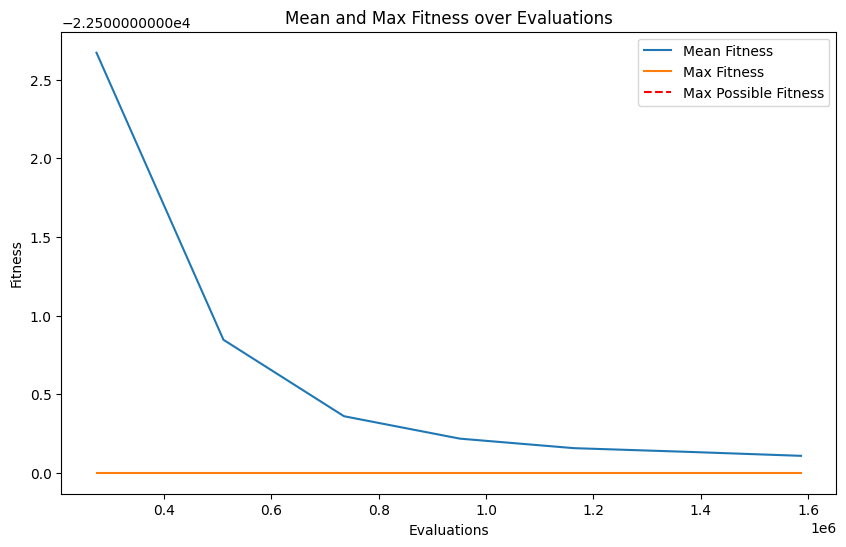

In [6]:
# Custom plot
plt.figure(figsize=(10, 6))
plt.plot(total_evaluations, mean_fitnesses, label='Mean Fitness')
plt.plot(total_evaluations, min_max_fitnesses, label='Max Fitness')
plt.axhline(y=problem.max_fitness, color='r', linestyle='--', label='Max Possible Fitness')
plt.xlabel('Evaluations')
plt.ylabel('Fitness')
plt.title('Mean and Max Fitness over Evaluations')
plt.legend()

# Save plot to W&B
wandb.log({"fitness_plot": wandb.Image(plt)})

# Finish the W&B run
wandb.finish()

In [7]:
population

tensor([[-1.,  1.,  1.,  ..., -1.,  1., -1.],
        [ 1., -1., -1.,  ...,  1.,  1.,  1.],
        [-1.,  1.,  1.,  ...,  1.,  1., -1.],
        ...,
        [ 1.,  1.,  1.,  ..., -1.,  1., -1.],
        [ 1., -1., -1.,  ...,  1., -1.,  1.],
        [-1.,  1., -1.,  ..., -1.,  1., -1.]])

In [8]:
fitnesses

tensor([-22500., -22500., -22500.,  ..., -22500., -22500., -22500.])

In [9]:
def find_extreme_indices(fitnesses, mode='high'):
    """
    Returns the indices of the highest or lowest values in the list based on the mode.

    Args:
        fitnesses (list or torch.Tensor): A list or tensor of fitness values.
        mode (str): A string that can be either 'high' or 'low'. Defaults to 'high'.

    Returns:
        list: A list of indices corresponding to the extreme values.
    """
    if mode not in ['high', 'low']:
        raise ValueError("Mode should be either 'high' or 'low'")

    if mode == 'high':
        extreme_value = max(fitnesses)
    else:
        extreme_value = min(fitnesses)

    return [i for i, value in enumerate(fitnesses) if value == extreme_value]

In [11]:
population[find_extreme_indices(fitnesses, mode='low')]

tensor([[-1.,  1.,  1.,  ..., -1.,  1., -1.],
        [ 1., -1., -1.,  ...,  1.,  1.,  1.],
        [-1.,  1.,  1.,  ...,  1.,  1., -1.],
        ...,
        [ 1.,  1.,  1.,  ..., -1.,  1., -1.],
        [ 1., -1., -1.,  ...,  1., -1.,  1.],
        [-1.,  1., -1.,  ..., -1.,  1., -1.]])